## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
Ans:從精度及loss來看batch size 16 跟 32最好,並且overfit的情況較輕微
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
Ans:batch size為 256的情況下,將BN改為放在activation之前感覺loss、精度及overfit的情況都差不多
3. 請於 BN 放在 Input Layer 後，並比較結果
Ans:batch size為 256的情況下,將BN改為放在input layer之後感覺loss、精度及overfit的情況都差不多,但validset的 loss跟精度有比較平滑,上下振盪較沒那麼劇烈

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95




In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch_setting in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch_setting = %.6f" % (batch_setting))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_setting, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-dropout-%1.4f" % (batch_setting)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0721 23:44:16.789867  5460 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0721 23:44:16.790866  5460 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 23:44:16.879871  5460 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 23:44:16.880867  5460 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 23:44:16.884875  5460 

Experiment with batch_setting = 2.000000


W0721 23:44:17.352865  5460 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0721 23:44:17.527868  5460 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 711s 14ms/step - loss: 2.2965 - acc: 0.1542 - val_loss: 2.1361 - val_acc: 0.2239
Epoch 2/50
50000/50000 [==============================] - 704s 14ms/step - loss: 2.2276 - acc: 0.1665 - val_loss: 2.1527 - val_acc: 0.1987
Epoch 3/50
50000/50000 [==============================] - 707s 14ms/step - loss: 2.2259 - acc: 0.1700 - val_loss: 2.2712 - val_acc: 0.2004
Epoch 4/50
50000/50000 [==============================] - 641s 13ms/step - loss: 2.2258 - acc: 0.1708 - val_loss: 2.2857 - val_acc: 0.1813
Epoch 5/50
50000/50000 [==============================] - 568s 11ms/step - loss: 2.2364 - acc: 0.1637 - val_loss: 2.4025 - val_acc: 0.1939
Epoch 6/50
50000/50000 [==============================] - 569s 11ms/step - loss: 2.2385 - acc: 0.1613 - val_loss: 2.3547 - val_acc: 0.1892s - loss: 2.2385 - ac
Epoch 7/50
50000/50000 [==============================] - 571s 11ms/step - loss: 2.2291 - acc: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 76s 2ms/step - loss: 1.8036 - acc: 0.3579 - val_loss: 1.6792 - val_acc: 0.3918
Epoch 2/50
50000/50000 [==============================] - 75s 2ms/step - loss: 1.6439 - acc: 0.4144 - val_loss: 1.6800 - val_acc: 0.3927
Epoch 3/50
50000/50000 [==============================] - 75s 2ms/step - loss: 1.5872 - acc: 0.4352 - val_loss: 1.7495 - val_acc: 0.3798
Epoch 4/50
50000/50000 [==============================] - 75s 2ms/step - loss: 1.5369 - acc: 0.4533 - val_loss: 1.5424 - val_acc: 0.4418
Epoch 5/50
50000/50000 [==============================] - 75s 2ms/step - loss: 1.5069 - acc: 0.4624 - val_loss: 1.5557 - val_acc: 0.4433
Epoch 6/50
50000/50000 [==============================] - 75s 2ms/step - loss: 1.4855 - acc: 0.4752 - val_loss: 1.4862 - val_acc: 0.4769
Epoch 7/50
50000/50000 [==============================] - 76s 2ms/step - loss: 1.4699 - acc: 0.4772 - val_loss: 1.4955 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 42s 832us/step - loss: 1.7285 - acc: 0.3890 - val_loss: 1.6531 - val_acc: 0.4191
Epoch 2/50
50000/50000 [==============================] - 42s 831us/step - loss: 1.5340 - acc: 0.4528 - val_loss: 1.5951 - val_acc: 0.4444
Epoch 3/50
50000/50000 [==============================] - 42s 845us/step - loss: 1.4598 - acc: 0.4825 - val_loss: 1.5542 - val_acc: 0.4522
Epoch 4/50
50000/50000 [==============================] - 42s 847us/step - loss: 1.4089 - acc: 0.5001 - val_loss: 1.4917 - val_acc: 0.4729
Epoch 5/50
50000/50000 [==============================] - 42s 843us/step - loss: 1.3670 - acc: 0.5132 - val_loss: 1.5257 - val_acc: 0.4667
Epoch 6/50
50000/50000 [==============================] - 42s 843us/step - loss: 1.3536 - acc: 0.5189 - val_loss: 1.6137 - val_acc: 0.4268
Epoch 7/50
50000/50000 [==============================] - 43s 850us/step - loss: 1.3199 - acc: 0.5319 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 316us/step - loss: 1.7631 - acc: 0.3876 - val_loss: 1.6557 - val_acc: 0.4089
Epoch 2/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.4948 - acc: 0.4760 - val_loss: 1.5556 - val_acc: 0.4532
Epoch 3/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.3964 - acc: 0.5096 - val_loss: 1.4987 - val_acc: 0.4690
Epoch 4/50
50000/50000 [==============================] - 15s 303us/step - loss: 1.3290 - acc: 0.5304 - val_loss: 1.5274 - val_acc: 0.4597
Epoch 5/50
50000/50000 [==============================] - 15s 303us/step - loss: 1.2659 - acc: 0.5556 - val_loss: 1.5238 - val_acc: 0.4683
Epoch 6/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.2116 - acc: 0.5756 - val_loss: 1.4571 - val_acc: 0.4869
Epoch 7/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.1642 - acc: 0.5907 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.8745 - acc: 0.3551 - val_loss: 1.7083 - val_acc: 0.4061
Epoch 2/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.5504 - acc: 0.4552 - val_loss: 1.6042 - val_acc: 0.4334
Epoch 3/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.4525 - acc: 0.4898 - val_loss: 1.6262 - val_acc: 0.4308
Epoch 4/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.3734 - acc: 0.5197 - val_loss: 1.5238 - val_acc: 0.4656
Epoch 5/50
50000/50000 [==============================] - 11s 216us/step - loss: 1.3105 - acc: 0.5404 - val_loss: 1.5038 - val_acc: 0.4768 lo
Epoch 6/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.2579 - acc: 0.5600 - val_loss: 1.5103 - val_acc: 0.4739
Epoch 7/50
50000/50000 [==============================] - 11s 214us/step - loss: 1.2096 - acc: 0.5786 - val_loss:

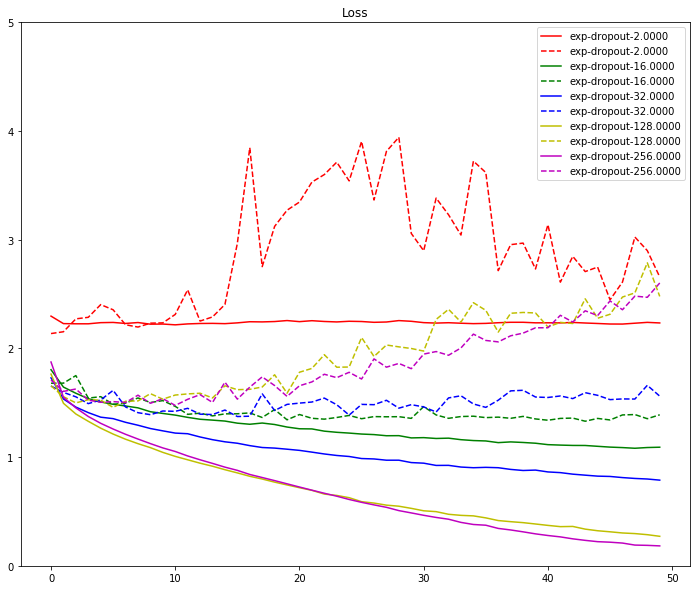

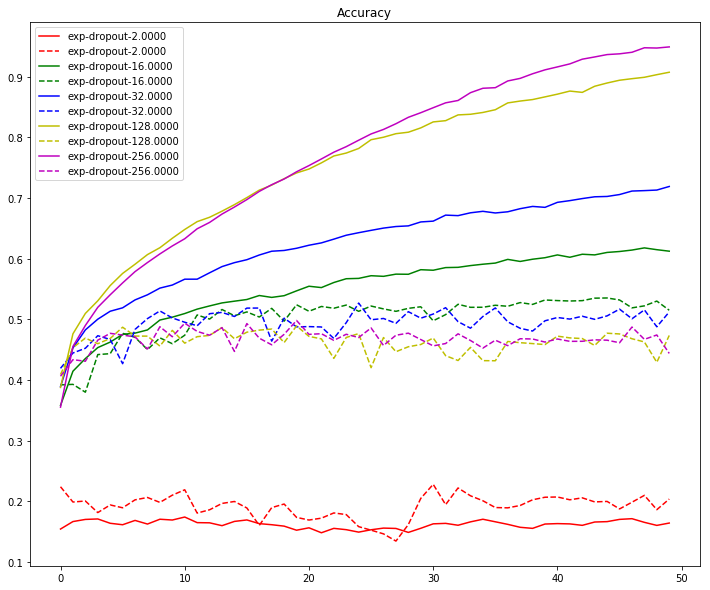

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","black",'gray','pink']

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i<9:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i<9:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
def build_mlp_2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)            
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with batch_setting = %.6f" % (batch_setting))
model = build_mlp_2(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss2 = model.history.history["loss"]
valid_loss2 = model.history.history["val_loss"]
train_acc2 = model.history.history["acc"]
valid_acc2 = model.history.history["val_acc"]

Experiment with batch_setting = 256.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (Non

50000/50000 [==============================] - 12s 248us/step - loss: 0.2161 - acc: 0.9404 - val_loss: 2.2592 - val_acc: 0.4766
Epoch 50/50
50000/50000 [==============================] - 12s 241us/step - loss: 0.1969 - acc: 0.9481 - val_loss: 2.2267 - val_acc: 0.4911


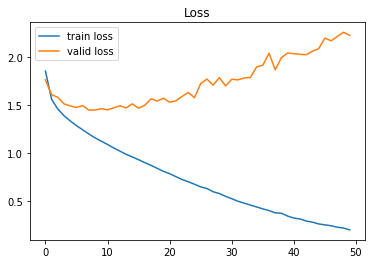

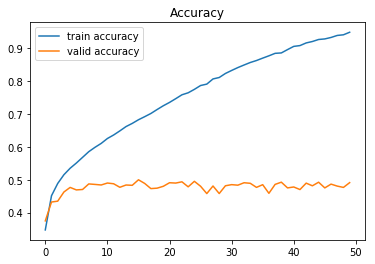

In [15]:
plt.plot(range(len(train_loss2)), train_loss2, label="train loss")
plt.plot(range(len(valid_loss2)), valid_loss2, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc2)), train_acc2, label="train accuracy")
plt.plot(range(len(valid_acc2)), valid_acc2, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [18]:
def build_mlp_3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    input_layer_bn = BatchNormalization()(input_layer)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer_bn)            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [19]:
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with batch_setting = %.6f" % (batch_setting))
model = build_mlp_3(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=batch_setting, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss3 = model.history.history["loss"]
valid_loss3 = model.history.history["val_loss"]
train_acc3 = model.history.history["acc"]
valid_acc3 = model.history.history["val_acc"]

Experiment with batch_setting = 256.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
___________________

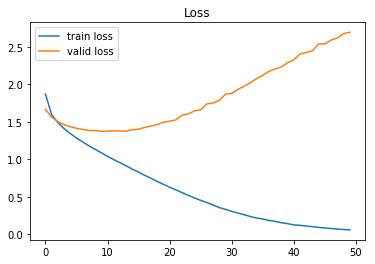

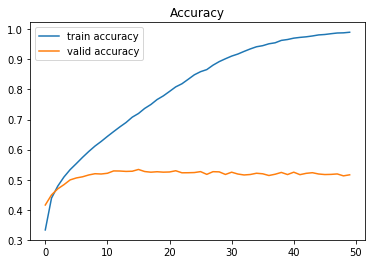

In [20]:
plt.plot(range(len(train_loss3)), train_loss3, label="train loss")
plt.plot(range(len(valid_loss3)), valid_loss3, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc3)), train_acc3, label="train accuracy")
plt.plot(range(len(valid_acc3)), valid_acc3, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()